# Basic algorithms for image analysis - Practice - Assignment 1

This notebook is presented as an Assignment for the course "Sensor Data Analytics" at Eötvos Lorand University (ELTE).

The goal for this assignment is to program the **simple box filter and fast running box filter**, and compare the execution times between both.

It is not allowed the use of python-libraries for performing the calculations.

## 1.- Import libraries

In [1]:
import cv2
import urllib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

## 2.- Read images

**Note:** We read the images online, internet connection needed

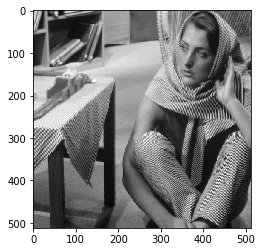

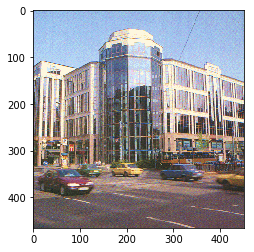

In [2]:
# Black & White image
req = urllib.request.urlopen('http://athos.vision.sztaki.hu/~mitya/education/sdapr/test-images/PNG/barbara.png')
arr = np.asarray(bytearray(req.read()))
img = cv2.imdecode(arr, -1) # 'Load it as it is'
req.close()

# Color image
req2 = urllib.request.urlopen('http://athos.vision.sztaki.hu/~mitya/education/sdapr/test-images/PNG/astoria.png')
arr2 = np.asarray(bytearray(req2.read()))
img_color = cv2.imdecode(arr2, -1) # 'Load it as it is'
req2.close()

# Display
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
plt.show()

## 3.- Function needed

Since all the operations need to be done without the use of libraries, we define the following functions:

1. **sum_mat**, 
        Input --> ndarray m, scalar dim
        Output --> the sum of the element of a matrix, divided by some scalar

In [3]:
def sum_mat(m, dim):
    rows = m.shape[0]
    cols = m.shape[1]
    s = 0
    for i in range(0,rows):
        for j in range(0,cols):
            s += m[i][j]/dim
    return s

2. **sum_vec**, 
        Input --> vector v, scalar dim
        Outputs --> the sum of the elements of the vector, each divided by dim

In [4]:
def sum_vec(v,dim):
    s = 0
    for i in range(0,len(v)):
        s += v[i]/dim
    return s

3. **handle_borders**, calculate the value of the output image borders based on the option chosen.
        Input --> pointers k,l ; kernel central coordinates startk, startl ; 
                  input_image ; number of rows and cols of the input_image r,c ;
                  type of border selected border_option; size of the kernel d
        Output --> value to introduce in the output image

In [5]:
def handle_borders(k,startk,l,startl,input_image,r,c, border_option, d):
    if border_option == 1:
        s = 0
    elif border_option == 2 or border_option == 3:
        s = -1
    else:
        lowh = (k-startk)%r
        highh = (k+startk+1)%r
        lowl = (l-startl)%c
        highl = (l+startl+1)%c
        s = 0

        if highh < lowh:
            if highl < lowl:
                s += sum_mat(input_image[lowh:r,lowl:c], d)
                s += sum_mat(input_image[0:highh, lowl:c], d)
                s += sum_mat(input_image[lowh:r,0:highl], d)
                s += sum_mat(input_image[0:highh, 0:highl], d)
            else:
                s += sum_mat(input_image[lowh:r,lowl:highl], d)
                s += sum_mat(input_image[0:highh,lowl:highl], d)
        else:
            s += sum_mat(input_image[lowh:highh,lowl:c], d)
            s += sum_mat(input_image[lowh:highh,0:highl], d)
            
    return s

4. **fill_borders**, compute the borders for "Mean value of output image" and "Nearest computed value"
        Input --> kernel central coordinates startk, startl ; number of rows and cols of the input_image r,c ;
                  new_image ; type of border selected border_option
        Output --> Final image

In [6]:
def fill_borders(starti,startj,new_image, r, c, border_option):
    if border_option == 2:
        new_image = np.where(new_image==-1,np.mean(new_image[starti:r-starti,startj:c-startj]), new_image)
    elif border_option == 3:
        for i in range(0,starti-1):
            new_image[starti-i-1,startj:c-startj] = new_image[starti-i,startj:c-startj]
            new_image[r-starti+i,startj:c-startj] = new_image[r-starti+i-1,startj:c-startj]
        for j in range(0,startj-1):
            new_image[:,startj-j-1] = new_image[:,startj-j]
            new_image[:,c-startj+j] = new_image[:,c-startj+j-1]
    return new_image

5. **running_box**, Compute one iteration of the running box algorithm
        Input --> Help matrix S ; pointers i,j ; kernel central coordinates startk, startl ;
                  Image ; size of the kernel f_length,f_height ; previous result ; dimension of the kernel dim
        Output --> New help matrix S ; new result 

In [8]:
def running_box(S,i,starti,j,startj, image,f_length,f_height, result, dim):
    if i == starti & j == startj:
        S = image[i-starti:i+starti+1,0:f_length]
        result = sum_mat(S,dim)
    else:
        result = result - sum_vec(S[:,(j-1)%f_length],dim) + sum_vec(image[i-starti:i+starti+1,j+startj],dim)
        S[:,(j-1)%f_length] = image[i-starti:i+starti+1,j+startj]
        
    return S, result   

6. **box_filter**, main function for calculating the filter
        Input --> image to be treated *image* ; size of the kernel _f_height, f_length_ ; 
                  type of border selected *border_option* ; type of algorithm (running or simple) running (boolean) ;
                  display option (boolean)
        Output --> Execution time end_time ; result image new_image ; display of the image

In [9]:
def box_filter(image,f_height, f_length, border_option, running, display):
    # border_option = 1 --> Fill with 0
    # border_option = 2 --> Mean value of output image
    # border_option = 3 --> Nearest computed value
    # border_option = 4 --> Periodic
    
    # 1.- Initialization
    start_time = time.time()
    
    rows = image.shape[0]
    cols = image.shape[1]
    
    new_image = np.zeros(image.shape)
    
    if running:
        S = np.zeros([f_height,f_length])
        result = 0
    
    starti = int(f_height/2)
    startj = int(f_length/2)
    
    dim = f_height*f_length
    
    # 2.- Loop through the elments of the output image
    
    for i in range(0,new_image.shape[0]):     
        for j in range(0,new_image.shape[1]):
            if i < starti or rows-i-1<starti or j < startj or cols-j-1<startj:
                # 2.1.- If its a border pixel, we compute based on the border option
                new_image[i][j] = handle_borders(i,starti,j,startj,image,rows,cols,border_option, dim)
            elif running:
                # 2.2.- Else if the running box filter is selected, we compute the new values
                S, result = running_box(S,i,starti,j,startj,image, f_length,f_height, result, dim)
                new_image[i][j] = result
            else:
                # 2.3.- Otherwise we go through the simple case
                new_image[i][j] = sum_mat(image[i-starti:i+starti+1,j-startj:j+startj+1], dim)
    
    # 3.- If the border option 2 or 3 is selected, we compute the borders
    if border_option in [2,3]:
        new_image = fill_borders(starti, startj, new_image, rows, cols, border_option)
    
    end_time = time.time()
    
    # 4.- Display
    print("Kernel size ", f_height,"x", f_length,". Execution time: ", end_time - start_time)    
    
    if display == True:
        plt.figure("title", figsize=(20,20))
        plt.subplot(121)
        plt.title("Original Image")
        plt.xticks([]), plt.yticks([])
        plt.imshow(image,cmap='gray')

        plt.subplot(122)
        plt.title("After filter")
        plt.xticks([]), plt.yticks([])
        plt.imshow(new_image,cmap='gray')
        
        plt.show()
    
    return end_time - start_time, new_image

    

## 4.- Execution

Now we loop throught the gray and white image and the color image with different kernels to compare the results

Running =  False
Color =  False
Kernel size  3 x 3 . Execution time:  11.8921639919281


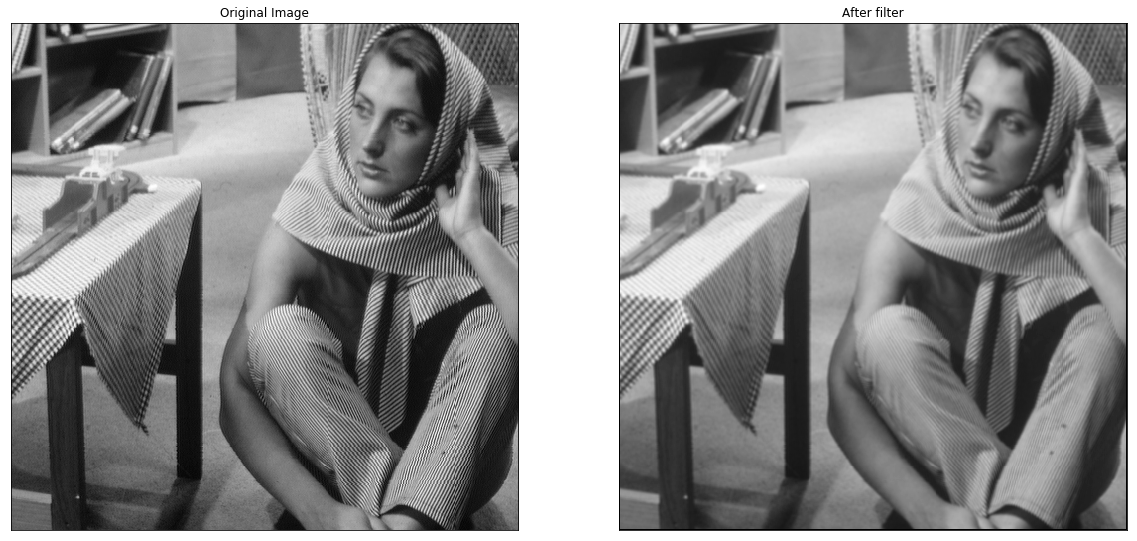

Kernel size  5 x 5 . Execution time:  31.07220220565796


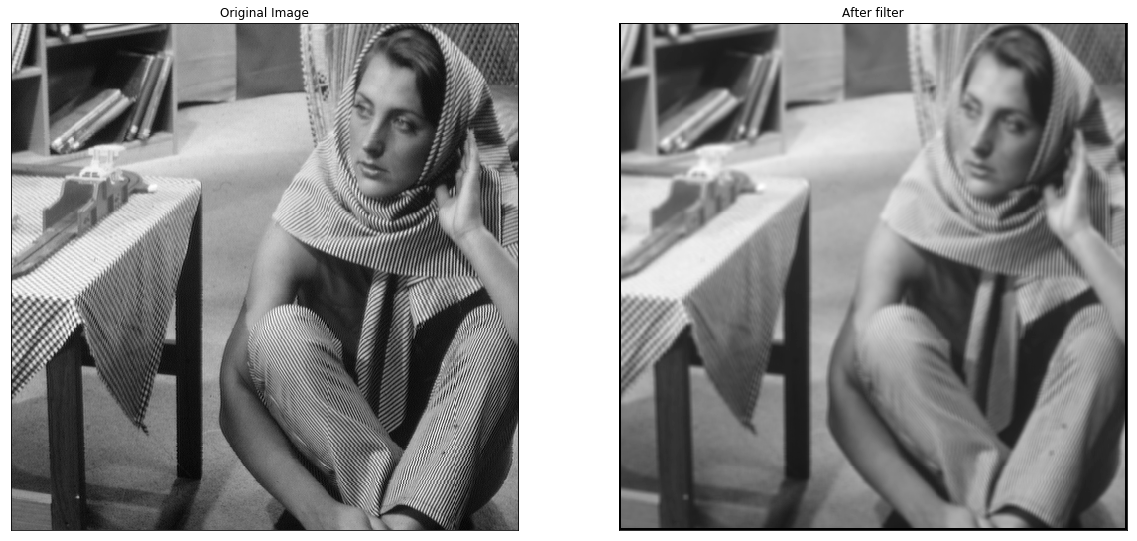

Kernel size  7 x 7 . Execution time:  62.460511922836304


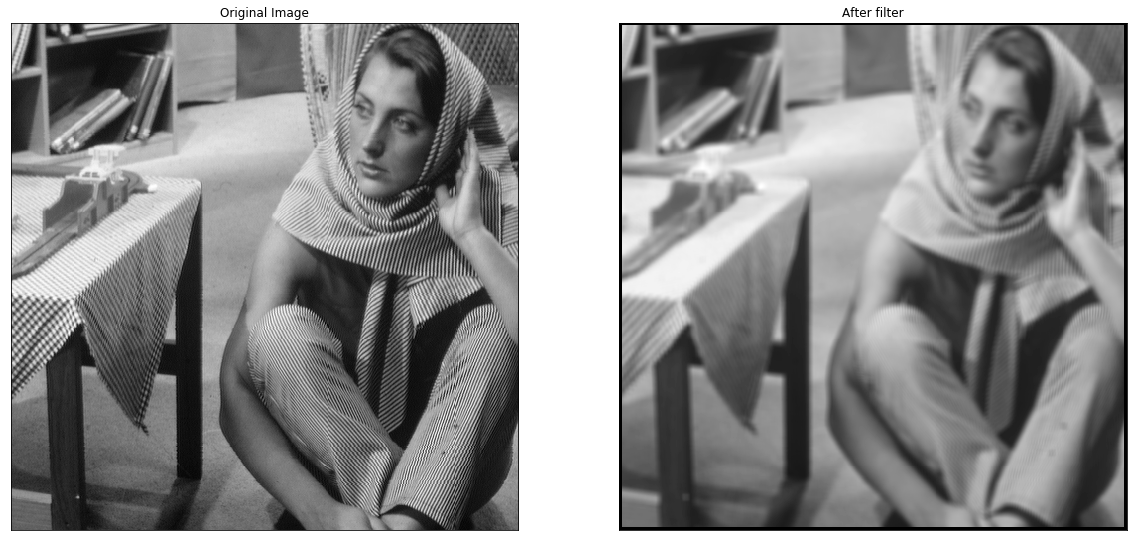

Kernel size  9 x 9 . Execution time:  90.70496654510498


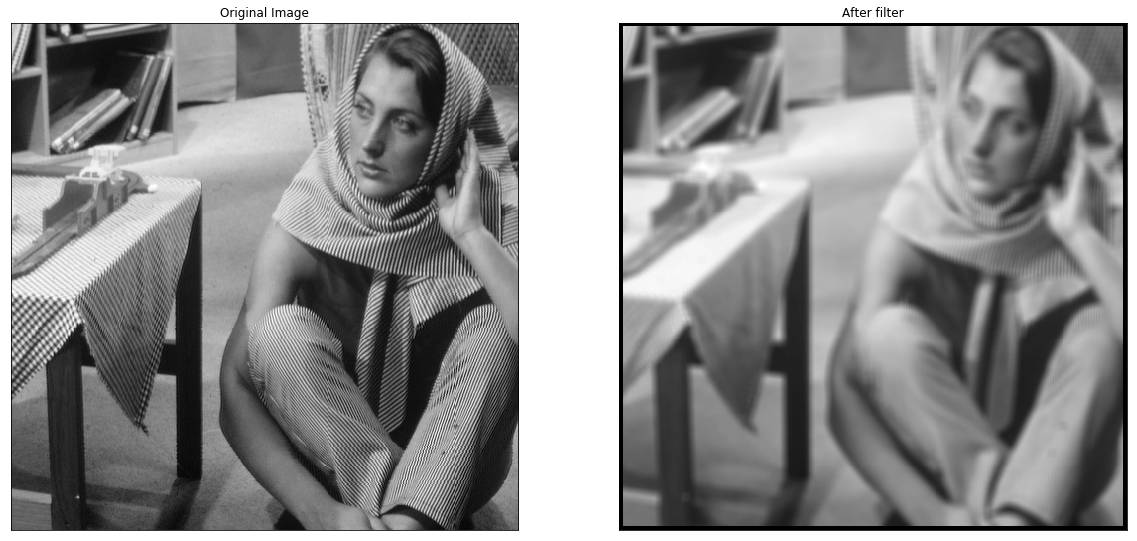

Kernel size  11 x 11 . Execution time:  117.40045595169067


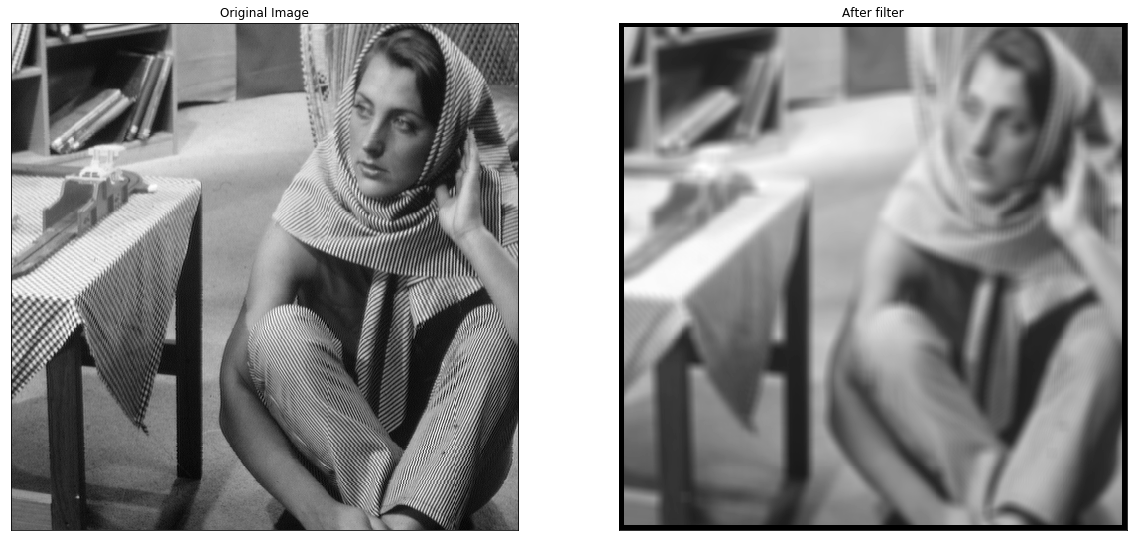

Kernel size  13 x 13 . Execution time:  177.24037194252014


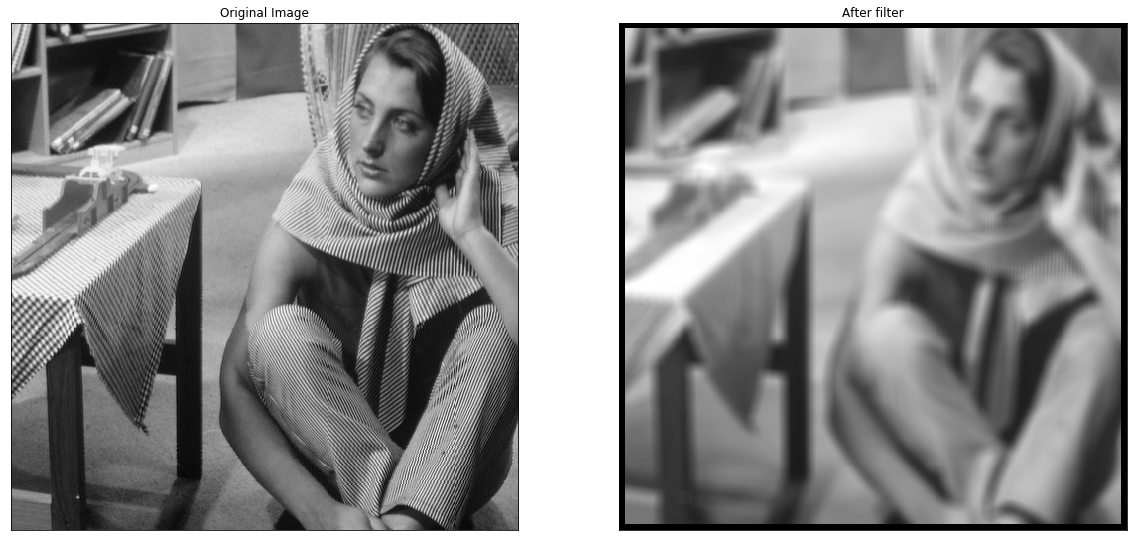

Color =  True
Kernel size  3 x 3 . Execution time:  10.394277811050415
Kernel size  3 x 3 . Execution time:  9.650247812271118
Kernel size  3 x 3 . Execution time:  9.998072862625122
Kernel size  5 x 5 . Execution time:  24.22003722190857
Kernel size  5 x 5 . Execution time:  24.17497491836548
Kernel size  5 x 5 . Execution time:  25.58543848991394
Kernel size  7 x 7 . Execution time:  48.53359866142273
Kernel size  7 x 7 . Execution time:  48.2873969078064
Kernel size  7 x 7 . Execution time:  48.440327882766724
Kernel size  9 x 9 . Execution time:  78.46612572669983
Kernel size  9 x 9 . Execution time:  85.35880470275879
Kernel size  9 x 9 . Execution time:  82.01706886291504
Kernel size  11 x 11 . Execution time:  128.6981976032257
Kernel size  11 x 11 . Execution time:  125.1280038356781
Kernel size  11 x 11 . Execution time:  125.15781569480896
Kernel size  13 x 13 . Execution time:  159.07413578033447
Kernel size  13 x 13 . Execution time:  135.67478919029236
Kernel size  13 x 13

In [11]:
test_gray = pd.DataFrame(columns=['Kernel dim', 'Kernel size', 'Time Simple', 'Time Simple/size', 'Time Running', 'Time running/size'])
test_color = pd.DataFrame(columns=['Kernel dim', 'Kernel size', 'Time Simple', 'Time Simple/size', 'Time Running', 'Time running/size'])

output_gray = []
output_color = []

border = 1

for j in [False, True]:
    print("Running = ", j)
    for color in [False, True]:
        print("Color = ", color)
        for i in [3,5,7,9,11,13]:
            t = 0
            if color:
                out_temp = np.zeros(img_color.shape)
                for r in range(0,3):
                    if (not j) & (not color):
                        ttemp, out = box_filter(img_color[:,:,r], i, i, border, j, True)
                    else:
                        ttemp, out = box_filter(img_color[:,:,r], i, i, border, j, False)
                    out_temp[:,:,r] = out
                    t += ttemp
                output_color.append(out)
            else:
                if (not j) & (not color):
                    t, out = box_filter(img, i, i, border, j, True)
                else:
                    t, out = box_filter(img, i, i, border, j, False)
                output_gray.append(out)
                
            if (not j) & color:
                test_color.loc[test_color.shape[0]] = [str(i) + "x" + str(i),i*i, t, t/(i*i),0,0]
            elif j & color :
                test_color.iloc[int((i-3)/2),4] = t
                test_color.iloc[int((i-3)/2),5] = t/(i*i)
            elif (not j) & (not color):
                test_gray.loc[test_gray.shape[0]] = [str(i) + "x" + str(i),i*i, t, t/(i*i),0,0]                
            elif j & (not color):
                test_gray.iloc[int((i-3)/2),4] = t
                test_gray.iloc[int((i-3)/2),5] = t/(i*i)

## 5.- Results

We print the results of the different kernel sizes (note that it is also possible to use not-squared kernels (but only with even dimensions)

In [10]:
test_color

Kernel dim Kernel size  Time Simple  Time Simple/size Time Running  \
0        3x3           9    19.088942          2.120994       13.997   
1        5x5          25    49.318063          1.972723       23.004   
2        7x7          49    92.039285          1.878353      28.4385   
3        9x9          81   147.748822          1.824060       32.767   
4      11x11         121   231.091140          1.909844      36.2091   
5      13x13         169   314.909960          1.863373      54.6191   

  Time running/size  
0           1.55523  
1          0.920161  
2          0.580377  
3          0.404531  
4          0.299249  
5           0.32319

In [11]:
test_gray

Kernel dim Kernel size  Time Simple  Time Simple/size Time Running  \
0        3x3           9     7.698030          0.855337      5.25996   
1        5x5          25    17.113041          0.684522      7.37103   
2        7x7          49    32.453960          0.662326       10.249   
3        9x9          81    54.588999          0.673938       13.429   
4      11x11         121    89.139198          0.736688        16.36   
5      13x13         169   121.711736          0.720188       18.356   

  Time running/size  
0           0.58444  
1          0.294841  
2          0.209163  
3           0.16579  
4          0.135207  
5          0.108616

## 6.- Conclusion

We can see that using the simple form of the box filter implementation the time grows based on the product of the dimensions of the kernel, meanwhile, the running box filter grows almos linear.